In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import copy
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   

os.environ["CUDA_VISIBLE_DEVICES"]="1"

import matplotlib.pyplot as plt
import torch.optim as optim


In [2]:
torch.manual_seed(0)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
CIFAR_SGD_trainloader = torch.utils.data.DataLoader(trainset, batch_size=500,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=8)


Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #print(npimg)
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(np.transpose(npimg))#, (1, 2, 0)))
    plt.show()

In [8]:
'''for i in range(5):
    tmp=trainset[i]
    fig=plt.figure
    plt.imshow(np.transpose(tmp[0],(1,2,0)))
    plt.show()
    print(classes[tmp[1]])'''

'for i in range(5):\n    tmp=trainset[i]\n    fig=plt.figure\n    plt.imshow(np.transpose(tmp[0],(1,2,0)))\n    plt.show()\n    print(classes[tmp[1]])'

In [9]:
'''# get some random training images
dataiter = iter(CIFAR_SGD_trainloader)
images, labels = dataiter.next()
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)'''

"# get some random training images\ndataiter = iter(CIFAR_SGD_trainloader)\nimages, labels = dataiter.next()\nprint(images.shape)\n# show images\nimshow(torchvision.utils.make_grid(images))\n# print labels\nprint(' '.join('%5s' % classes[labels[j]] for j in range(4)))\n# print size of single image\nprint(images[1].shape)"

In [10]:
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

In [11]:
def cifar_iid(dataset, num_users):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    #num_items=8
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [12]:
'''cifar_iid_dataset=cifar_iid(trainset,2)
print(cifar_iid_dataset)'''

'cifar_iid_dataset=cifar_iid(trainset,2)\nprint(cifar_iid_dataset)'

In [13]:
'''num_clients=2
num_items=8

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_iid_dataset[x])
    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)
    dataiter=iter(CIFAR_client_trainloader)
    for i in range(int(num_items/4)):
        images,labels=dataiter.next()
        print(images.shape)
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        imshow(torchvision.utils.make_grid(images))
        print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
        #print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=8\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_iid_dataset[x])\n    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)\n    dataiter=iter(CIFAR_client_trainloader)\n    for i in range(int(num_items/4)):\n        images,labels=dataiter.next()\n        print(images.shape)\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        imshow(torchvision.utils.make_grid(images))\n        print(\' \'.join(\'%5s\' % classes[labels[j]] for j in range(4)))\n        #print(classes[trainset[index_list[i]][1]])'

In [14]:
'''num_clients=2
num_items=5

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_iid_dataset[x])
    for i in range(num_items):
        image=trainset[index_list[i]][0]
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        plt.imshow(np.transpose(image,(1,2,0)))
        plt.show()
        print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=5\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_iid_dataset[x])\n    for i in range(num_items):\n        image=trainset[index_list[i]][0]\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        plt.imshow(np.transpose(image,(1,2,0)))\n        plt.show()\n        print(classes[trainset[index_list[i]][1]])'

In [15]:
def cifar_noniid(dataset, num_users):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    #num_shards, num_imgs = 200, 250
    #num_shards, num_imgs = 200, 250
    class_per_user=1
    num_shards=num_users*class_per_user
    num_imgs=int(len(dataset)/num_shards)
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([],dtype='int64') for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    # labels = dataset.train_labels.numpy()
    #labels = np.array(dataset.train_labels)

    labels=[]
    for element in dataset:
        labels.append(int(element[1]))
    #print(type(labels[0]))
    labels=np.array(labels)
    #labels=labels.astype('int64')
    # sort labels
    
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, class_per_user, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

In [16]:
'''cifar_noniid_dataset=cifar_noniid(trainset,2)
print(cifar_noniid_dataset)'''

'cifar_noniid_dataset=cifar_noniid(trainset,2)\nprint(cifar_noniid_dataset)'

In [17]:
'''num_clients=2
num_items=250*2

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_noniid_dataset[x])
    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)
    dataiter=iter(CIFAR_client_trainloader)
    for i in range(int(num_items/4)):
        images,labels=dataiter.next()
        print(images.shape)
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        imshow(torchvision.utils.make_grid(images))
        print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
        #print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=250*2\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_noniid_dataset[x])\n    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)\n    dataiter=iter(CIFAR_client_trainloader)\n    for i in range(int(num_items/4)):\n        images,labels=dataiter.next()\n        print(images.shape)\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        imshow(torchvision.utils.make_grid(images))\n        print(\' \'.join(\'%5s\' % classes[labels[j]] for j in range(4)))\n        #print(classes[trainset[index_list[i]][1]])'

In [18]:
'''num_clients=2
num_items=5
num_imgs=250
cifar_noniid_dataset=cifar_noniid(trainset, num_clients)
#print(cifar_noniid_dataset)
for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_noniid_dataset[x])
    #print(index_list)
    #print(index_list[0])
    #print(type(index_list[0]))
    for y in range(2):
        for i in range(num_items):
            image=trainset[index_list[i+num_imgs*y]][0]
            #print(image)
            fig=plt.figure
            plt.imshow(np.transpose(image,(1,2,0)))
            plt.show()
            print(classes[trainset[index_list[i+num_imgs*y]][1]])'''

'num_clients=2\nnum_items=5\nnum_imgs=250\ncifar_noniid_dataset=cifar_noniid(trainset, num_clients)\n#print(cifar_noniid_dataset)\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_noniid_dataset[x])\n    #print(index_list)\n    #print(index_list[0])\n    #print(type(index_list[0]))\n    for y in range(2):\n        for i in range(num_items):\n            image=trainset[index_list[i+num_imgs*y]][0]\n            #print(image)\n            fig=plt.figure\n            plt.imshow(np.transpose(image,(1,2,0)))\n            plt.show()\n            print(classes[trainset[index_list[i+num_imgs*y]][1]])'

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        #self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = (self.fc2(x))
        
        return x




In [20]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,momentum=0.5)
loss_train = []
acc_train=[]

In [22]:
for epoch in range(0):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(CIFAR_SGD_trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(labels)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
       
        
    if epoch%1==0:
        loss_train.append(loss)
        print(f"epoch: {epoch}")
        print(' Average loss {:.3f}'.format( loss))
        for j in range(1):
            net.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %d %%' % (
                100 * correct / total))
        acc_train.append(100 * correct / total)

    net.train()

    '''# 통계를 출력합니다.
    running_loss += loss.item()
    if i % 2000 == 1999:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0'''

print('Finished Training')

Finished Training


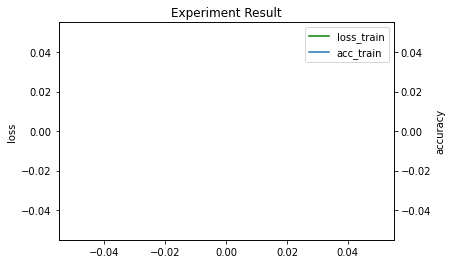

In [23]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [24]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 10 %


In [25]:
class LocalUpdate(object):
    def __init__(self, lr,local_epoch,device,batch_size, dataset=None, idxs=None):
        self.lr=lr
        self.local_epoch=local_epoch
        self.device=device
        self.loss_func = nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs), batch_size=batch_size, shuffle=True)

    def train(self, net):
        net.train()
        # train and update
        optimizer = torch.optim.SGD(net.parameters(), lr=self.lr)

        epoch_loss = []
        for iter in range(self.local_epoch):
            batch_loss = []
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.device), labels.to(self.device)
                net.zero_grad()
                log_probs = net(images)
                loss = self.loss_func(log_probs, labels)
                loss.backward()
                optimizer.step()
                #if batch_idx % 10 == 0:
                #    print('Update Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                #        iter, batch_idx * len(images), len(self.ldr_train.dataset),
                #               100. * batch_idx / len(self.ldr_train), loss.item()))
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        return net.state_dict(), sum(epoch_loss) / len(epoch_loss)

cifar10 FedAvg iid로 학습

In [26]:
device=torch.device('cuda')
FedAvg_model=Net().cuda()
criterion= nn.CrossEntropyLoss().to(device)
FedAvg_model.train()
epoch_loss = []

# Set optimizer for the local updates

optimizer = torch.optim.SGD(FedAvg_model.parameters(), lr=0.001,
                                momentum=0.9)
global_epoch=501

In [27]:
weight_saved=FedAvg_model.state_dict()

In [28]:
C=0.05
num_clients=100
#CIFAR_noniid_dataset=cifar_noniid(trainset, num_clients)
CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

In [29]:
for epoch in range(global_epoch):
    local_weight=[]
    local_loss=[]
    m=max(int(C*num_clients),1)
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    print(f"This is global {epoch} epoch")
    for user in selected_user:
        local_setting=LocalUpdate(lr=0.1,local_epoch=5,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_iid_dataset[user])
        weight,loss=local_setting.train(net=copy.deepcopy(FedAvg_model).to(device))
        local_weight.append(copy.deepcopy(weight))
        #print(local_weight[0].keys())
        local_loss.append(copy.deepcopy(loss))
    FedAvg_weight=copy.deepcopy(local_weight[0])
    for key in FedAvg_weight.keys():
        for i in range(1,len(local_weight)):
            FedAvg_weight[key]+=local_weight[i][key]
        FedAvg_weight[key]/=len(local_weight)
    FedAvg_model.load_state_dict(FedAvg_weight)
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

This is global 0 epoch


<ipython-input-10-257b199ae30d>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


 Average loss 2.287
Accuracy of the network on the 10000 test images: 20.270000 %
This is global 1 epoch
 Average loss 2.133
Accuracy of the network on the 10000 test images: 27.050000 %
This is global 2 epoch
 Average loss 1.995
Accuracy of the network on the 10000 test images: 31.470000 %
This is global 3 epoch
 Average loss 1.909
Accuracy of the network on the 10000 test images: 33.070000 %
This is global 4 epoch
 Average loss 1.793
Accuracy of the network on the 10000 test images: 37.210000 %
This is global 5 epoch
 Average loss 1.719
Accuracy of the network on the 10000 test images: 39.730000 %
This is global 6 epoch
 Average loss 1.636
Accuracy of the network on the 10000 test images: 40.700000 %
This is global 7 epoch
 Average loss 1.577
Accuracy of the network on the 10000 test images: 43.150000 %
This is global 8 epoch
 Average loss 1.485
Accuracy of the network on the 10000 test images: 44.700000 %
This is global 9 epoch
 Average loss 1.407
Accuracy of the network on the 1000

 Average loss 0.259
Accuracy of the network on the 10000 test images: 62.800000 %
This is global 79 epoch
 Average loss 0.340
Accuracy of the network on the 10000 test images: 62.290000 %
This is global 80 epoch
 Average loss 0.275
Accuracy of the network on the 10000 test images: 62.360000 %
This is global 81 epoch
 Average loss 0.323
Accuracy of the network on the 10000 test images: 62.360000 %
This is global 82 epoch
 Average loss 0.307
Accuracy of the network on the 10000 test images: 62.680000 %
This is global 83 epoch
 Average loss 0.217
Accuracy of the network on the 10000 test images: 62.810000 %
This is global 84 epoch
 Average loss 0.210
Accuracy of the network on the 10000 test images: 62.510000 %
This is global 85 epoch
 Average loss 0.300
Accuracy of the network on the 10000 test images: 62.660000 %
This is global 86 epoch
 Average loss 0.296
Accuracy of the network on the 10000 test images: 62.810000 %
This is global 87 epoch
 Average loss 0.307
Accuracy of the network on

 Average loss 0.141
Accuracy of the network on the 10000 test images: 63.840000 %
This is global 156 epoch
 Average loss 0.212
Accuracy of the network on the 10000 test images: 63.610000 %
This is global 157 epoch
 Average loss 0.227
Accuracy of the network on the 10000 test images: 63.440000 %
This is global 158 epoch
 Average loss 0.190
Accuracy of the network on the 10000 test images: 63.850000 %
This is global 159 epoch
 Average loss 0.152
Accuracy of the network on the 10000 test images: 64.090000 %
This is global 160 epoch
 Average loss 0.205
Accuracy of the network on the 10000 test images: 63.800000 %
This is global 161 epoch
 Average loss 0.149
Accuracy of the network on the 10000 test images: 63.840000 %
This is global 162 epoch
 Average loss 0.183
Accuracy of the network on the 10000 test images: 63.820000 %
This is global 163 epoch
 Average loss 0.164
Accuracy of the network on the 10000 test images: 63.810000 %
This is global 164 epoch
 Average loss 0.217
Accuracy of the n

 Average loss 0.165
Accuracy of the network on the 10000 test images: 64.040000 %
This is global 233 epoch
 Average loss 0.109
Accuracy of the network on the 10000 test images: 64.410000 %
This is global 234 epoch
 Average loss 0.126
Accuracy of the network on the 10000 test images: 64.120000 %
This is global 235 epoch
 Average loss 0.175
Accuracy of the network on the 10000 test images: 64.090000 %
This is global 236 epoch
 Average loss 0.139
Accuracy of the network on the 10000 test images: 64.130000 %
This is global 237 epoch
 Average loss 0.160
Accuracy of the network on the 10000 test images: 64.080000 %
This is global 238 epoch
 Average loss 0.093
Accuracy of the network on the 10000 test images: 64.470000 %
This is global 239 epoch
 Average loss 0.140
Accuracy of the network on the 10000 test images: 63.720000 %
This is global 240 epoch
 Average loss 0.141
Accuracy of the network on the 10000 test images: 64.010000 %
This is global 241 epoch
 Average loss 0.131
Accuracy of the n

 Average loss 0.101
Accuracy of the network on the 10000 test images: 63.970000 %
This is global 310 epoch
 Average loss 0.157
Accuracy of the network on the 10000 test images: 63.820000 %
This is global 311 epoch
 Average loss 0.109
Accuracy of the network on the 10000 test images: 63.850000 %
This is global 312 epoch
 Average loss 0.117
Accuracy of the network on the 10000 test images: 63.720000 %
This is global 313 epoch
 Average loss 0.098
Accuracy of the network on the 10000 test images: 63.990000 %
This is global 314 epoch
 Average loss 0.134
Accuracy of the network on the 10000 test images: 64.120000 %
This is global 315 epoch
 Average loss 0.102
Accuracy of the network on the 10000 test images: 63.960000 %
This is global 316 epoch
 Average loss 0.125
Accuracy of the network on the 10000 test images: 64.230000 %
This is global 317 epoch
 Average loss 0.122
Accuracy of the network on the 10000 test images: 63.930000 %
This is global 318 epoch
 Average loss 0.098
Accuracy of the n

 Average loss 0.106
Accuracy of the network on the 10000 test images: 63.930000 %
This is global 387 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 64.400000 %
This is global 388 epoch
 Average loss 0.108
Accuracy of the network on the 10000 test images: 63.390000 %
This is global 389 epoch
 Average loss 0.120
Accuracy of the network on the 10000 test images: 63.600000 %
This is global 390 epoch
 Average loss 0.066
Accuracy of the network on the 10000 test images: 63.810000 %
This is global 391 epoch
 Average loss 0.102
Accuracy of the network on the 10000 test images: 63.810000 %
This is global 392 epoch
 Average loss 0.079
Accuracy of the network on the 10000 test images: 63.580000 %
This is global 393 epoch
 Average loss 0.054
Accuracy of the network on the 10000 test images: 63.770000 %
This is global 394 epoch
 Average loss 0.105
Accuracy of the network on the 10000 test images: 63.500000 %
This is global 395 epoch
 Average loss 0.082
Accuracy of the n

 Average loss 0.079
Accuracy of the network on the 10000 test images: 63.440000 %
This is global 464 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 64.010000 %
This is global 465 epoch
 Average loss 0.080
Accuracy of the network on the 10000 test images: 63.810000 %
This is global 466 epoch
 Average loss 0.149
Accuracy of the network on the 10000 test images: 62.830000 %
This is global 467 epoch
 Average loss 0.109
Accuracy of the network on the 10000 test images: 63.000000 %
This is global 468 epoch
 Average loss 0.114
Accuracy of the network on the 10000 test images: 63.430000 %
This is global 469 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 63.740000 %
This is global 470 epoch
 Average loss 0.097
Accuracy of the network on the 10000 test images: 63.770000 %
This is global 471 epoch
 Average loss 0.093
Accuracy of the network on the 10000 test images: 63.780000 %
This is global 472 epoch
 Average loss 0.052
Accuracy of the n

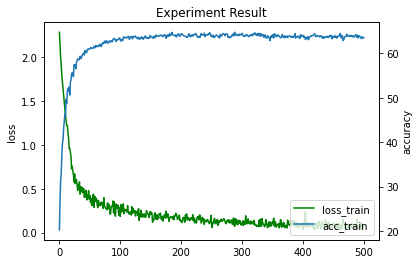

In [30]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [31]:
PATH = './data/CIFAR_iid_net_moreparam.pth'
torch.save( FedAvg_model.state_dict(), PATH)

cifar10 FedAvg Non-iid로 학습


In [32]:
device=torch.device('cuda')
FedAvg_model=Net().cuda()
criterion= nn.CrossEntropyLoss().to(device)
FedAvg_model.train()
epoch_loss = []

# Set optimizer for the local updates

optimizer = torch.optim.SGD(FedAvg_model.parameters(), lr=0.001,
                                momentum=0.9)
global_epoch=5001

In [33]:
weight_saved=FedAvg_model.state_dict()

In [34]:
C=0.05
num_clients=100
CIFAR_noniid_dataset=cifar_noniid(trainset, num_clients)
#CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

In [35]:
for epoch in range(global_epoch):
    local_weight=[]
    local_loss=[]
    m=max(int(C*num_clients),1)
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    print(f"This is global {epoch} epoch")
    for user in selected_user:
        local_setting=LocalUpdate(lr=0.1,local_epoch=5,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_noniid_dataset[user])
        weight,loss=local_setting.train(net=copy.deepcopy(FedAvg_model).to(device))
        local_weight.append(copy.deepcopy(weight))
        #print(local_weight[0].keys())
        local_loss.append(copy.deepcopy(loss))
    FedAvg_weight=copy.deepcopy(local_weight[0])
    for key in FedAvg_weight.keys():
        for i in range(1,len(local_weight)):
            FedAvg_weight[key]+=local_weight[i][key]
        FedAvg_weight[key]/=len(local_weight)
    FedAvg_model.load_state_dict(FedAvg_weight)
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

This is global 0 epoch


<ipython-input-10-257b199ae30d>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image), torch.tensor(label)


 Average loss 0.133
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1 epoch
 Average loss 0.058
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2 epoch
 Average loss 0.176
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3 epoch
 Average loss 0.095
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4 epoch
 Average loss 0.064
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 5 epoch
 Average loss 0.090
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 6 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 7 epoch
 Average loss 0.068
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 8 epoch
 Average loss 0.096
Accuracy of the network on the 10000 test images: 9.990000 %
This is global 9 epoch
 Average loss 0.071
Accuracy of the network on the 10000

 Average loss 0.040
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 79 epoch
 Average loss 0.052
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 80 epoch
 Average loss 0.056
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 81 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 82 epoch
 Average loss 0.061
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 83 epoch
 Average loss 0.069
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 84 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 85 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 86 epoch
 Average loss 0.047
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 87 epoch
 Average loss 0.068
Accuracy of the network on

 Average loss 0.053
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 156 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 157 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 158 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 159 epoch
 Average loss 0.069
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 160 epoch
 Average loss 0.047
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 161 epoch
 Average loss 0.047
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 162 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 163 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 164 epoch
 Average loss 0.052
Accuracy of the n

 Average loss 0.059
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 233 epoch
 Average loss 0.049
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 234 epoch
 Average loss 0.054
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 235 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 236 epoch
 Average loss 0.066
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 237 epoch
 Average loss 0.060
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 238 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 239 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 240 epoch
 Average loss 0.054
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 241 epoch
 Average loss 0.049
Accuracy of the n

 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 310 epoch
 Average loss 0.052
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 311 epoch
 Average loss 0.051
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 312 epoch
 Average loss 0.049
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 313 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 314 epoch
 Average loss 0.087
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 315 epoch
 Average loss 0.058
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 316 epoch
 Average loss 0.044
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 317 epoch
 Average loss 0.074
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 318 epoch
 Average loss 0.063
Accuracy of the n

 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 387 epoch
 Average loss 0.055
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 388 epoch
 Average loss 0.060
Accuracy of the network on the 10000 test images: 10.030000 %
This is global 389 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 390 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 391 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 392 epoch
 Average loss 0.065
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 393 epoch
 Average loss 0.056
Accuracy of the network on the 10000 test images: 12.410000 %
This is global 394 epoch
 Average loss 0.055
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 395 epoch
 Average loss 0.081
Accuracy of the n

 Average loss 0.058
Accuracy of the network on the 10000 test images: 15.750000 %
This is global 464 epoch
 Average loss 0.044
Accuracy of the network on the 10000 test images: 16.990000 %
This is global 465 epoch
 Average loss 0.051
Accuracy of the network on the 10000 test images: 13.070000 %
This is global 466 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 467 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 468 epoch
 Average loss 0.062
Accuracy of the network on the 10000 test images: 16.560000 %
This is global 469 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 9.990000 %
This is global 470 epoch
 Average loss 0.055
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 471 epoch
 Average loss 0.053
Accuracy of the network on the 10000 test images: 14.710000 %
This is global 472 epoch
 Average loss 0.039
Accuracy of the ne

 Average loss 0.061
Accuracy of the network on the 10000 test images: 14.460000 %
This is global 541 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 14.020000 %
This is global 542 epoch
 Average loss 0.051
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 543 epoch
 Average loss 0.071
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 544 epoch
 Average loss 0.099
Accuracy of the network on the 10000 test images: 16.600000 %
This is global 545 epoch
 Average loss 0.060
Accuracy of the network on the 10000 test images: 12.840000 %
This is global 546 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 10.560000 %
This is global 547 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 548 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 549 epoch
 Average loss 0.049
Accuracy of the n

 Average loss 0.040
Accuracy of the network on the 10000 test images: 17.110000 %
This is global 618 epoch
 Average loss 0.049
Accuracy of the network on the 10000 test images: 16.530000 %
This is global 619 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 14.630000 %
This is global 620 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 12.550000 %
This is global 621 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 13.350000 %
This is global 622 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 12.050000 %
This is global 623 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 624 epoch
 Average loss 0.060
Accuracy of the network on the 10000 test images: 11.570000 %
This is global 625 epoch
 Average loss 0.055
Accuracy of the network on the 10000 test images: 10.530000 %
This is global 626 epoch
 Average loss 0.057
Accuracy of the n

 Average loss 0.044
Accuracy of the network on the 10000 test images: 14.940000 %
This is global 695 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 15.610000 %
This is global 696 epoch
 Average loss 0.049
Accuracy of the network on the 10000 test images: 16.370000 %
This is global 697 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 18.960000 %
This is global 698 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 16.610000 %
This is global 699 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 16.660000 %
This is global 700 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 701 epoch
 Average loss 0.089
Accuracy of the network on the 10000 test images: 17.650000 %
This is global 702 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 703 epoch
 Average loss 0.045
Accuracy of the n

 Average loss 0.059
Accuracy of the network on the 10000 test images: 15.000000 %
This is global 772 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 17.950000 %
This is global 773 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 11.310000 %
This is global 774 epoch
 Average loss 0.054
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 775 epoch
 Average loss 0.064
Accuracy of the network on the 10000 test images: 10.380000 %
This is global 776 epoch
 Average loss 0.070
Accuracy of the network on the 10000 test images: 18.940000 %
This is global 777 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 17.580000 %
This is global 778 epoch
 Average loss 0.060
Accuracy of the network on the 10000 test images: 13.930000 %
This is global 779 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 18.780000 %
This is global 780 epoch
 Average loss 0.031
Accuracy of the n

 Average loss 0.042
Accuracy of the network on the 10000 test images: 14.460000 %
This is global 849 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 15.360000 %
This is global 850 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 16.310000 %
This is global 851 epoch
 Average loss 0.098
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 852 epoch
 Average loss 0.067
Accuracy of the network on the 10000 test images: 15.270000 %
This is global 853 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 18.910000 %
This is global 854 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 18.010000 %
This is global 855 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 14.460000 %
This is global 856 epoch
 Average loss 0.049
Accuracy of the network on the 10000 test images: 17.830000 %
This is global 857 epoch
 Average loss 0.038
Accuracy of the n

 Average loss 0.064
Accuracy of the network on the 10000 test images: 16.510000 %
This is global 926 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 16.010000 %
This is global 927 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 21.880000 %
This is global 928 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 14.020000 %
This is global 929 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 18.900000 %
This is global 930 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 18.920000 %
This is global 931 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 17.040000 %
This is global 932 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 16.950000 %
This is global 933 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 11.070000 %
This is global 934 epoch
 Average loss 0.067
Accuracy of the n

 Average loss 0.033
Accuracy of the network on the 10000 test images: 19.150000 %
This is global 1003 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 21.680000 %
This is global 1004 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 22.990000 %
This is global 1005 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 19.480000 %
This is global 1006 epoch
 Average loss 0.058
Accuracy of the network on the 10000 test images: 24.320000 %
This is global 1007 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 20.420000 %
This is global 1008 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 17.330000 %
This is global 1009 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 18.960000 %
This is global 1010 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 17.270000 %
This is global 1011 epoch
 Average loss 0.038
Accuracy

 Average loss 0.042
Accuracy of the network on the 10000 test images: 15.460000 %
This is global 1079 epoch
 Average loss 0.047
Accuracy of the network on the 10000 test images: 23.650000 %
This is global 1080 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 29.230000 %
This is global 1081 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 21.060000 %
This is global 1082 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 23.310000 %
This is global 1083 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 17.560000 %
This is global 1084 epoch
 Average loss 0.061
Accuracy of the network on the 10000 test images: 21.290000 %
This is global 1085 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 28.410000 %
This is global 1086 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 24.150000 %
This is global 1087 epoch
 Average loss 0.032
Accuracy

 Average loss 0.053
Accuracy of the network on the 10000 test images: 15.320000 %
This is global 1155 epoch
 Average loss 0.044
Accuracy of the network on the 10000 test images: 18.420000 %
This is global 1156 epoch
 Average loss 0.062
Accuracy of the network on the 10000 test images: 21.700000 %
This is global 1157 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 27.020000 %
This is global 1158 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 23.510000 %
This is global 1159 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 20.170000 %
This is global 1160 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 26.430000 %
This is global 1161 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 23.140000 %
This is global 1162 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 20.280000 %
This is global 1163 epoch
 Average loss 0.062
Accuracy

 Average loss 0.036
Accuracy of the network on the 10000 test images: 18.480000 %
This is global 1231 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 12.220000 %
This is global 1232 epoch
 Average loss 0.061
Accuracy of the network on the 10000 test images: 24.810000 %
This is global 1233 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 25.610000 %
This is global 1234 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 26.590000 %
This is global 1235 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 26.700000 %
This is global 1236 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 18.450000 %
This is global 1237 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 23.390000 %
This is global 1238 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 18.380000 %
This is global 1239 epoch
 Average loss 0.040
Accuracy

 Average loss 0.047
Accuracy of the network on the 10000 test images: 12.600000 %
This is global 1307 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 21.730000 %
This is global 1308 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 21.110000 %
This is global 1309 epoch
 Average loss 0.076
Accuracy of the network on the 10000 test images: 19.440000 %
This is global 1310 epoch
 Average loss 0.069
Accuracy of the network on the 10000 test images: 26.950000 %
This is global 1311 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 19.770000 %
This is global 1312 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 30.200000 %
This is global 1313 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 23.650000 %
This is global 1314 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 27.020000 %
This is global 1315 epoch
 Average loss 0.038
Accuracy

 Average loss 0.043
Accuracy of the network on the 10000 test images: 23.630000 %
This is global 1383 epoch
 Average loss 0.052
Accuracy of the network on the 10000 test images: 27.510000 %
This is global 1384 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 31.730000 %
This is global 1385 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 25.630000 %
This is global 1386 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 20.120000 %
This is global 1387 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 26.840000 %
This is global 1388 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 26.520000 %
This is global 1389 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 33.070000 %
This is global 1390 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 26.230000 %
This is global 1391 epoch
 Average loss 0.050
Accuracy

 Average loss 0.039
Accuracy of the network on the 10000 test images: 23.660000 %
This is global 1459 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 28.350000 %
This is global 1460 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 29.140000 %
This is global 1461 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 30.690000 %
This is global 1462 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 27.840000 %
This is global 1463 epoch
 Average loss 0.051
Accuracy of the network on the 10000 test images: 36.370000 %
This is global 1464 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 28.550000 %
This is global 1465 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 20.200000 %
This is global 1466 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 22.530000 %
This is global 1467 epoch
 Average loss 0.042
Accuracy

 Average loss 0.025
Accuracy of the network on the 10000 test images: 35.540000 %
This is global 1535 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 30.110000 %
This is global 1536 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 26.610000 %
This is global 1537 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 32.590000 %
This is global 1538 epoch
 Average loss 0.044
Accuracy of the network on the 10000 test images: 22.060000 %
This is global 1539 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 22.210000 %
This is global 1540 epoch
 Average loss 0.044
Accuracy of the network on the 10000 test images: 31.070000 %
This is global 1541 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 38.000000 %
This is global 1542 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 36.390000 %
This is global 1543 epoch
 Average loss 0.036
Accuracy

 Average loss 0.031
Accuracy of the network on the 10000 test images: 24.010000 %
This is global 1611 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 42.370000 %
This is global 1612 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 25.080000 %
This is global 1613 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 21.310000 %
This is global 1614 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 35.750000 %
This is global 1615 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 31.870000 %
This is global 1616 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 32.920000 %
This is global 1617 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 34.920000 %
This is global 1618 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 27.690000 %
This is global 1619 epoch
 Average loss 0.047
Accuracy

 Average loss 0.034
Accuracy of the network on the 10000 test images: 36.400000 %
This is global 1687 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 31.380000 %
This is global 1688 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 34.450000 %
This is global 1689 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 22.640000 %
This is global 1690 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 37.460000 %
This is global 1691 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 30.800000 %
This is global 1692 epoch
 Average loss 0.047
Accuracy of the network on the 10000 test images: 30.120000 %
This is global 1693 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 33.280000 %
This is global 1694 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 36.810000 %
This is global 1695 epoch
 Average loss 0.031
Accuracy

 Average loss 0.050
Accuracy of the network on the 10000 test images: 38.480000 %
This is global 1763 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 31.540000 %
This is global 1764 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 33.150000 %
This is global 1765 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 23.950000 %
This is global 1766 epoch
 Average loss 0.053
Accuracy of the network on the 10000 test images: 29.960000 %
This is global 1767 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 24.860000 %
This is global 1768 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 19.230000 %
This is global 1769 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 19.360000 %
This is global 1770 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 33.320000 %
This is global 1771 epoch
 Average loss 0.039
Accuracy

 Average loss 0.033
Accuracy of the network on the 10000 test images: 40.280000 %
This is global 1839 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 42.720000 %
This is global 1840 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 43.840000 %
This is global 1841 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 41.070000 %
This is global 1842 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 37.830000 %
This is global 1843 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 33.770000 %
This is global 1844 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 35.070000 %
This is global 1845 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 40.170000 %
This is global 1846 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 26.570000 %
This is global 1847 epoch
 Average loss 0.027
Accuracy

 Average loss 0.042
Accuracy of the network on the 10000 test images: 43.090000 %
This is global 1915 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 30.840000 %
This is global 1916 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 24.530000 %
This is global 1917 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 39.570000 %
This is global 1918 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 35.770000 %
This is global 1919 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 36.060000 %
This is global 1920 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 34.180000 %
This is global 1921 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 35.520000 %
This is global 1922 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 34.710000 %
This is global 1923 epoch
 Average loss 0.029
Accuracy

 Average loss 0.023
Accuracy of the network on the 10000 test images: 31.650000 %
This is global 1991 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 39.110000 %
This is global 1992 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 36.740000 %
This is global 1993 epoch
 Average loss 0.036
Accuracy of the network on the 10000 test images: 44.790000 %
This is global 1994 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 36.110000 %
This is global 1995 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 39.680000 %
This is global 1996 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 43.950000 %
This is global 1997 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 36.850000 %
This is global 1998 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 22.140000 %
This is global 1999 epoch
 Average loss 0.054
Accuracy

 Average loss 0.032
Accuracy of the network on the 10000 test images: 34.900000 %
This is global 2067 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 42.110000 %
This is global 2068 epoch
 Average loss 0.033
Accuracy of the network on the 10000 test images: 41.050000 %
This is global 2069 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 39.740000 %
This is global 2070 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 21.120000 %
This is global 2071 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 40.760000 %
This is global 2072 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 45.690000 %
This is global 2073 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 31.880000 %
This is global 2074 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 44.440000 %
This is global 2075 epoch
 Average loss 0.024
Accuracy

 Average loss 0.046
Accuracy of the network on the 10000 test images: 29.450000 %
This is global 2143 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 38.240000 %
This is global 2144 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 27.180000 %
This is global 2145 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 19.080000 %
This is global 2146 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 41.670000 %
This is global 2147 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 25.360000 %
This is global 2148 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 40.050000 %
This is global 2149 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 36.820000 %
This is global 2150 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 36.020000 %
This is global 2151 epoch
 Average loss 0.022
Accuracy

 Average loss 0.031
Accuracy of the network on the 10000 test images: 41.290000 %
This is global 2219 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 40.590000 %
This is global 2220 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 28.320000 %
This is global 2221 epoch
 Average loss 0.054
Accuracy of the network on the 10000 test images: 32.110000 %
This is global 2222 epoch
 Average loss 0.056
Accuracy of the network on the 10000 test images: 32.090000 %
This is global 2223 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 21.530000 %
This is global 2224 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 36.030000 %
This is global 2225 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 33.060000 %
This is global 2226 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 34.770000 %
This is global 2227 epoch
 Average loss 0.030
Accuracy

 Average loss 0.025
Accuracy of the network on the 10000 test images: 51.070000 %
This is global 2295 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 49.660000 %
This is global 2296 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 46.040000 %
This is global 2297 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 41.630000 %
This is global 2298 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 47.000000 %
This is global 2299 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 41.450000 %
This is global 2300 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 37.400000 %
This is global 2301 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 44.300000 %
This is global 2302 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 37.540000 %
This is global 2303 epoch
 Average loss 0.033
Accuracy

 Average loss 0.028
Accuracy of the network on the 10000 test images: 40.000000 %
This is global 2371 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 38.340000 %
This is global 2372 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 46.680000 %
This is global 2373 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 51.810000 %
This is global 2374 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 43.730000 %
This is global 2375 epoch
 Average loss 0.033
Accuracy of the network on the 10000 test images: 38.610000 %
This is global 2376 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 44.420000 %
This is global 2377 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 46.380000 %
This is global 2378 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 41.300000 %
This is global 2379 epoch
 Average loss 0.032
Accuracy

 Average loss 0.023
Accuracy of the network on the 10000 test images: 43.700000 %
This is global 2447 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 41.820000 %
This is global 2448 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 45.360000 %
This is global 2449 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 45.750000 %
This is global 2450 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 38.460000 %
This is global 2451 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 49.190000 %
This is global 2452 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 43.580000 %
This is global 2453 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 47.140000 %
This is global 2454 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 49.040000 %
This is global 2455 epoch
 Average loss 0.024
Accuracy

 Average loss 0.033
Accuracy of the network on the 10000 test images: 47.690000 %
This is global 2523 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 49.220000 %
This is global 2524 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 47.190000 %
This is global 2525 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 44.720000 %
This is global 2526 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 45.080000 %
This is global 2527 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 51.190000 %
This is global 2528 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 50.770000 %
This is global 2529 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 48.270000 %
This is global 2530 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 45.660000 %
This is global 2531 epoch
 Average loss 0.029
Accuracy

 Average loss 0.029
Accuracy of the network on the 10000 test images: 54.670000 %
This is global 2599 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 52.110000 %
This is global 2600 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 55.410000 %
This is global 2601 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 52.940000 %
This is global 2602 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 50.010000 %
This is global 2603 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 39.830000 %
This is global 2604 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 44.490000 %
This is global 2605 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 39.330000 %
This is global 2606 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 42.050000 %
This is global 2607 epoch
 Average loss 0.027
Accuracy

 Average loss 0.025
Accuracy of the network on the 10000 test images: 40.470000 %
This is global 2675 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 41.760000 %
This is global 2676 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 37.810000 %
This is global 2677 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 45.440000 %
This is global 2678 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 42.870000 %
This is global 2679 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 31.320000 %
This is global 2680 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 25.230000 %
This is global 2681 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 35.770000 %
This is global 2682 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 49.760000 %
This is global 2683 epoch
 Average loss 0.023
Accuracy

 Average loss 0.029
Accuracy of the network on the 10000 test images: 57.900000 %
This is global 2751 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 43.080000 %
This is global 2752 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 44.750000 %
This is global 2753 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 51.060000 %
This is global 2754 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 24.780000 %
This is global 2755 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 43.860000 %
This is global 2756 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 49.870000 %
This is global 2757 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 54.340000 %
This is global 2758 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 39.920000 %
This is global 2759 epoch
 Average loss 0.028
Accuracy

 Average loss 0.018
Accuracy of the network on the 10000 test images: 46.050000 %
This is global 2827 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 49.970000 %
This is global 2828 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 50.640000 %
This is global 2829 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 57.200000 %
This is global 2830 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 50.040000 %
This is global 2831 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 40.880000 %
This is global 2832 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 52.920000 %
This is global 2833 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 31.160000 %
This is global 2834 epoch
 Average loss 0.044
Accuracy of the network on the 10000 test images: 34.010000 %
This is global 2835 epoch
 Average loss 0.029
Accuracy

 Average loss 0.020
Accuracy of the network on the 10000 test images: 45.240000 %
This is global 2903 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 47.590000 %
This is global 2904 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 54.920000 %
This is global 2905 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 45.290000 %
This is global 2906 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 46.200000 %
This is global 2907 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 52.900000 %
This is global 2908 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 53.290000 %
This is global 2909 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 50.020000 %
This is global 2910 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 43.940000 %
This is global 2911 epoch
 Average loss 0.025
Accuracy

 Average loss 0.025
Accuracy of the network on the 10000 test images: 37.270000 %
This is global 2979 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 43.930000 %
This is global 2980 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 49.350000 %
This is global 2981 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 44.250000 %
This is global 2982 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 60.880000 %
This is global 2983 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 49.680000 %
This is global 2984 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 54.290000 %
This is global 2985 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 51.890000 %
This is global 2986 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 54.350000 %
This is global 2987 epoch
 Average loss 0.026
Accuracy

 Average loss 0.017
Accuracy of the network on the 10000 test images: 53.420000 %
This is global 3055 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 52.900000 %
This is global 3056 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 46.830000 %
This is global 3057 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 44.920000 %
This is global 3058 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 34.090000 %
This is global 3059 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 45.690000 %
This is global 3060 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 50.400000 %
This is global 3061 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 48.970000 %
This is global 3062 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 57.910000 %
This is global 3063 epoch
 Average loss 0.018
Accuracy

 Average loss 0.027
Accuracy of the network on the 10000 test images: 54.150000 %
This is global 3131 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 50.990000 %
This is global 3132 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 49.710000 %
This is global 3133 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 54.740000 %
This is global 3134 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 57.530000 %
This is global 3135 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 50.300000 %
This is global 3136 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 46.890000 %
This is global 3137 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 50.860000 %
This is global 3138 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 51.820000 %
This is global 3139 epoch
 Average loss 0.031
Accuracy

 Average loss 0.019
Accuracy of the network on the 10000 test images: 54.270000 %
This is global 3207 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 46.480000 %
This is global 3208 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 48.990000 %
This is global 3209 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 48.490000 %
This is global 3210 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 50.270000 %
This is global 3211 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 54.510000 %
This is global 3212 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 50.750000 %
This is global 3213 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 51.970000 %
This is global 3214 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 50.730000 %
This is global 3215 epoch
 Average loss 0.022
Accuracy

 Average loss 0.023
Accuracy of the network on the 10000 test images: 52.320000 %
This is global 3283 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 57.230000 %
This is global 3284 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 50.120000 %
This is global 3285 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 45.420000 %
This is global 3286 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 46.920000 %
This is global 3287 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 50.590000 %
This is global 3288 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 51.470000 %
This is global 3289 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 51.510000 %
This is global 3290 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 49.710000 %
This is global 3291 epoch
 Average loss 0.012
Accuracy

 Average loss 0.024
Accuracy of the network on the 10000 test images: 57.370000 %
This is global 3359 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 58.620000 %
This is global 3360 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 60.500000 %
This is global 3361 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 56.610000 %
This is global 3362 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 60.830000 %
This is global 3363 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 53.130000 %
This is global 3364 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 53.630000 %
This is global 3365 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 58.120000 %
This is global 3366 epoch
 Average loss 0.012
Accuracy of the network on the 10000 test images: 55.860000 %
This is global 3367 epoch
 Average loss 0.019
Accuracy

 Average loss 0.016
Accuracy of the network on the 10000 test images: 58.290000 %
This is global 3435 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 61.170000 %
This is global 3436 epoch
 Average loss 0.012
Accuracy of the network on the 10000 test images: 58.760000 %
This is global 3437 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 45.960000 %
This is global 3438 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 56.500000 %
This is global 3439 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 56.590000 %
This is global 3440 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 53.270000 %
This is global 3441 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 57.190000 %
This is global 3442 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 55.640000 %
This is global 3443 epoch
 Average loss 0.029
Accuracy

 Average loss 0.021
Accuracy of the network on the 10000 test images: 60.830000 %
This is global 3511 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 58.910000 %
This is global 3512 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 50.890000 %
This is global 3513 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 50.500000 %
This is global 3514 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 44.650000 %
This is global 3515 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 51.940000 %
This is global 3516 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 51.170000 %
This is global 3517 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 55.480000 %
This is global 3518 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 47.460000 %
This is global 3519 epoch
 Average loss 0.016
Accuracy

 Average loss 0.021
Accuracy of the network on the 10000 test images: 55.390000 %
This is global 3587 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 57.280000 %
This is global 3588 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 54.200000 %
This is global 3589 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 51.420000 %
This is global 3590 epoch
 Average loss 0.010
Accuracy of the network on the 10000 test images: 51.530000 %
This is global 3591 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 49.730000 %
This is global 3592 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 50.830000 %
This is global 3593 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 53.940000 %
This is global 3594 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 49.230000 %
This is global 3595 epoch
 Average loss 0.016
Accuracy

 Average loss 0.011
Accuracy of the network on the 10000 test images: 57.810000 %
This is global 3663 epoch
 Average loss 0.008
Accuracy of the network on the 10000 test images: 52.550000 %
This is global 3664 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 61.380000 %
This is global 3665 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 60.090000 %
This is global 3666 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 64.000000 %
This is global 3667 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 61.010000 %
This is global 3668 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 56.980000 %
This is global 3669 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 53.480000 %
This is global 3670 epoch
 Average loss 0.010
Accuracy of the network on the 10000 test images: 43.100000 %
This is global 3671 epoch
 Average loss 0.030
Accuracy

 Average loss 0.017
Accuracy of the network on the 10000 test images: 41.520000 %
This is global 3739 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 55.080000 %
This is global 3740 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 60.410000 %
This is global 3741 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 52.600000 %
This is global 3742 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 58.510000 %
This is global 3743 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 58.210000 %
This is global 3744 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 58.060000 %
This is global 3745 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 55.630000 %
This is global 3746 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 50.450000 %
This is global 3747 epoch
 Average loss 0.017
Accuracy

 Average loss 0.021
Accuracy of the network on the 10000 test images: 52.320000 %
This is global 3815 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 52.270000 %
This is global 3816 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 54.560000 %
This is global 3817 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 58.050000 %
This is global 3818 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 45.820000 %
This is global 3819 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 55.180000 %
This is global 3820 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 59.390000 %
This is global 3821 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 56.880000 %
This is global 3822 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 55.960000 %
This is global 3823 epoch
 Average loss 0.025
Accuracy

 Average loss 0.017
Accuracy of the network on the 10000 test images: 62.220000 %
This is global 3891 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 62.400000 %
This is global 3892 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 53.430000 %
This is global 3893 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 51.970000 %
This is global 3894 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 53.410000 %
This is global 3895 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 57.730000 %
This is global 3896 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 55.230000 %
This is global 3897 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 54.010000 %
This is global 3898 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 51.040000 %
This is global 3899 epoch
 Average loss 0.012
Accuracy

 Average loss 0.022
Accuracy of the network on the 10000 test images: 61.670000 %
This is global 3967 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 59.640000 %
This is global 3968 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 64.040000 %
This is global 3969 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 55.490000 %
This is global 3970 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 57.050000 %
This is global 3971 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 51.540000 %
This is global 3972 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 41.390000 %
This is global 3973 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 59.710000 %
This is global 3974 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 59.220000 %
This is global 3975 epoch
 Average loss 0.024
Accuracy

 Average loss 0.023
Accuracy of the network on the 10000 test images: 49.730000 %
This is global 4043 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 44.870000 %
This is global 4044 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 64.020000 %
This is global 4045 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 62.300000 %
This is global 4046 epoch
 Average loss 0.011
Accuracy of the network on the 10000 test images: 60.830000 %
This is global 4047 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 61.250000 %
This is global 4048 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 48.830000 %
This is global 4049 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 63.480000 %
This is global 4050 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 64.200000 %
This is global 4051 epoch
 Average loss 0.015
Accuracy

 Average loss 0.017
Accuracy of the network on the 10000 test images: 59.330000 %
This is global 4119 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 62.790000 %
This is global 4120 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 60.790000 %
This is global 4121 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 57.730000 %
This is global 4122 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 62.320000 %
This is global 4123 epoch
 Average loss 0.012
Accuracy of the network on the 10000 test images: 53.840000 %
This is global 4124 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 58.160000 %
This is global 4125 epoch
 Average loss 0.011
Accuracy of the network on the 10000 test images: 56.920000 %
This is global 4126 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 54.330000 %
This is global 4127 epoch
 Average loss 0.014
Accuracy

 Average loss 0.027
Accuracy of the network on the 10000 test images: 62.020000 %
This is global 4195 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 52.300000 %
This is global 4196 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 57.210000 %
This is global 4197 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 57.360000 %
This is global 4198 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 65.560000 %
This is global 4199 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 62.600000 %
This is global 4200 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 59.640000 %
This is global 4201 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 55.260000 %
This is global 4202 epoch
 Average loss 0.019
Accuracy of the network on the 10000 test images: 57.250000 %
This is global 4203 epoch
 Average loss 0.008
Accuracy

 Average loss 0.014
Accuracy of the network on the 10000 test images: 51.680000 %
This is global 4271 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 60.290000 %
This is global 4272 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 58.860000 %
This is global 4273 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 65.580000 %
This is global 4274 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 58.770000 %
This is global 4275 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 59.410000 %
This is global 4276 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 60.020000 %
This is global 4277 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 60.550000 %
This is global 4278 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 60.520000 %
This is global 4279 epoch
 Average loss 0.019
Accuracy

 Average loss 0.013
Accuracy of the network on the 10000 test images: 61.450000 %
This is global 4347 epoch
 Average loss 0.009
Accuracy of the network on the 10000 test images: 58.740000 %
This is global 4348 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 58.560000 %
This is global 4349 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 59.310000 %
This is global 4350 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 60.840000 %
This is global 4351 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 62.050000 %
This is global 4352 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 62.380000 %
This is global 4353 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 64.350000 %
This is global 4354 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 62.810000 %
This is global 4355 epoch
 Average loss 0.018
Accuracy

 Average loss 0.015
Accuracy of the network on the 10000 test images: 64.000000 %
This is global 4423 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 62.160000 %
This is global 4424 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 65.990000 %
This is global 4425 epoch
 Average loss 0.012
Accuracy of the network on the 10000 test images: 65.440000 %
This is global 4426 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 65.920000 %
This is global 4427 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 64.300000 %
This is global 4428 epoch
 Average loss 0.010
Accuracy of the network on the 10000 test images: 46.280000 %
This is global 4429 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 56.090000 %
This is global 4430 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 64.250000 %
This is global 4431 epoch
 Average loss 0.011
Accuracy

 Average loss 0.018
Accuracy of the network on the 10000 test images: 62.780000 %
This is global 4499 epoch
 Average loss 0.006
Accuracy of the network on the 10000 test images: 61.610000 %
This is global 4500 epoch
 Average loss 0.011
Accuracy of the network on the 10000 test images: 63.160000 %
This is global 4501 epoch
 Average loss 0.011
Accuracy of the network on the 10000 test images: 64.030000 %
This is global 4502 epoch
 Average loss 0.010
Accuracy of the network on the 10000 test images: 64.710000 %
This is global 4503 epoch
 Average loss 0.007
Accuracy of the network on the 10000 test images: 59.350000 %
This is global 4504 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 62.070000 %
This is global 4505 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 64.560000 %
This is global 4506 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 66.330000 %
This is global 4507 epoch
 Average loss 0.015
Accuracy

 Average loss 0.014
Accuracy of the network on the 10000 test images: 58.980000 %
This is global 4575 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 55.690000 %
This is global 4576 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 60.250000 %
This is global 4577 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 61.340000 %
This is global 4578 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 47.210000 %
This is global 4579 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 54.360000 %
This is global 4580 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 58.000000 %
This is global 4581 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 56.710000 %
This is global 4582 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 54.950000 %
This is global 4583 epoch
 Average loss 0.016
Accuracy

 Average loss 0.019
Accuracy of the network on the 10000 test images: 65.950000 %
This is global 4651 epoch
 Average loss 0.010
Accuracy of the network on the 10000 test images: 61.090000 %
This is global 4652 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 58.580000 %
This is global 4653 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 58.970000 %
This is global 4654 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 62.770000 %
This is global 4655 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 63.570000 %
This is global 4656 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 59.560000 %
This is global 4657 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 59.820000 %
This is global 4658 epoch
 Average loss 0.011
Accuracy of the network on the 10000 test images: 59.370000 %
This is global 4659 epoch
 Average loss 0.013
Accuracy

 Average loss 0.021
Accuracy of the network on the 10000 test images: 62.800000 %
This is global 4727 epoch
 Average loss 0.012
Accuracy of the network on the 10000 test images: 62.760000 %
This is global 4728 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 64.800000 %
This is global 4729 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 59.880000 %
This is global 4730 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 55.500000 %
This is global 4731 epoch
 Average loss 0.011
Accuracy of the network on the 10000 test images: 62.630000 %
This is global 4732 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 54.010000 %
This is global 4733 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 61.920000 %
This is global 4734 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 66.590000 %
This is global 4735 epoch
 Average loss 0.013
Accuracy

 Average loss 0.017
Accuracy of the network on the 10000 test images: 66.450000 %
This is global 4803 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 58.570000 %
This is global 4804 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 54.250000 %
This is global 4805 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 58.490000 %
This is global 4806 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 64.280000 %
This is global 4807 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 57.720000 %
This is global 4808 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 60.700000 %
This is global 4809 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 65.710000 %
This is global 4810 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 59.870000 %
This is global 4811 epoch
 Average loss 0.020
Accuracy

 Average loss 0.014
Accuracy of the network on the 10000 test images: 64.450000 %
This is global 4879 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 65.340000 %
This is global 4880 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 63.650000 %
This is global 4881 epoch
 Average loss 0.014
Accuracy of the network on the 10000 test images: 54.670000 %
This is global 4882 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 62.210000 %
This is global 4883 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 66.100000 %
This is global 4884 epoch
 Average loss 0.010
Accuracy of the network on the 10000 test images: 66.340000 %
This is global 4885 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 62.340000 %
This is global 4886 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 60.290000 %
This is global 4887 epoch
 Average loss 0.017
Accuracy

 Average loss 0.017
Accuracy of the network on the 10000 test images: 62.690000 %
This is global 4955 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 63.790000 %
This is global 4956 epoch
 Average loss 0.012
Accuracy of the network on the 10000 test images: 61.260000 %
This is global 4957 epoch
 Average loss 0.017
Accuracy of the network on the 10000 test images: 61.960000 %
This is global 4958 epoch
 Average loss 0.015
Accuracy of the network on the 10000 test images: 57.880000 %
This is global 4959 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 49.070000 %
This is global 4960 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 61.080000 %
This is global 4961 epoch
 Average loss 0.020
Accuracy of the network on the 10000 test images: 61.980000 %
This is global 4962 epoch
 Average loss 0.009
Accuracy of the network on the 10000 test images: 52.440000 %
This is global 4963 epoch
 Average loss 0.033
Accuracy

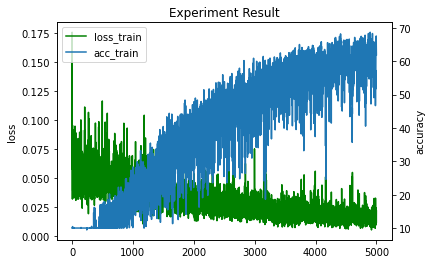

In [36]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [37]:
PATH = './data/CIFAR_noniid_net_moreparam.pth'
torch.save( FedAvg_model.state_dict(), PATH)

In [38]:
print(max(acc_train))

68.67
